In [24]:
import keras
import pandas as pd
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [329]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam, RMSprop
from keras.utils import to_categorical
import keras.backend as K

In [37]:
csv_data_15feat = pd.read_csv('15features.csv') # 15 feature
display(csv_data_15feat.head()), display(csv_data_15feat.shape)
dataset_columns = csv_data_15feat.columns

train_path = 'seen-dataset/TrainingSet/' # img pair
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
print("Size of training images",len(train_images))
print("Size of validation image",len(val_images))

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(13570, 16)

Size of training images 12846
Size of validation image 952


In [40]:
# Feature length
f = []
for col in dataset_columns[1:]:
    f.append(csv_data_15feat[col].unique().shape[0])
f,len(f)

feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data_15feat[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

# Data generation

In [204]:
def datagen(batch_size,image_path,list_of_writers,csv_feature, vshift = (-20,20) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
        writer_index = np.random.randint(0,len(list_of_writers))
        imagename = list_of_writers[writer_index]
        features = csv_feature[csv_feature['imagename']==imagename].values # one row in dataset
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1 # shape (1,15)
        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1]) # random shift along row direction
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1))) # input image is shifted
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features) # stack feature with shape (1,15) along row direction
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose() # shape (15 features, num of sample)
            out_cat_features = []
            for i in range(feature_list.shape[0]):
                # Each element in out_cat_features is a 64-batch one hot row vector, representing one feature.
                # There are totally 15 such element(15 features), feature value is converted to one hot vector
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
                
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    
def data_test_plot(data_gen):
    inputs,o = next(data_gen)
    print("Shape of input",inputs.shape)
    print("Shape of output category example: ",o[0].shape, o[1].shape)
    bits=[]
    for op in o:
        bits.append(np.argmax(op, axis=1)[0]+1)
    print("The feature values of a sample: ",bits)
    print("=====================================")
    print("Plot images in this sample batch: ")
    for r in range(8):
        f,ax = plt.subplots(1,8)
        f.subplots_adjust(hspace = .00, wspace=.15)
        f.set_size_inches(15,5)
        for c in range (8):
            if c+r*8>=inputs.shape[0]:
                continue
            ax[c].imshow(inputs[c+r*8].reshape((64,64)))
            ax[c].axis('off')

In [196]:
def datagen_norepeat(batch_size,image_path,list_of_writers,csv_feature, vshift = (-20,20) ,vis=False):
    counter = 0
    writer_index_list=[]
    num_all=len(list_of_writers)
    arr=np.arange(0,num_all)
    np.random.shuffle(arr)
    start=0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
        if start>=num_all:
            start=0
            np.random.shuffle(arr)
            continue
        end=start+batch_size
        if end>num_all:
            writer_index_list=np.copy(arr[start:])
            start=0
            np.random.shuffle(arr)
        else:
#             print(start, end)
#             print(arr[start:end])
            writer_index_list=np.copy(arr[start:end])
            start=start+batch_size
        for writer_index in writer_index_list:
            writer_index = np.random.randint(0,len(list_of_writers))
            imagename = list_of_writers[writer_index]
            features = csv_feature[csv_feature['imagename']==imagename].values # one row in dataset
            if len(features)==0:
    #             print('no features', imagename)
                continue
            features = features[0][1:]-1 # shape (1,15)
            loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
            rand = np.random.randint(vshift[0],vshift[1]) # random shift along row direction
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

            x.append(255.0-loaded_image_shifted.reshape((64,64,1))) # input image is shifted
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(imagename[:4])
            imagenames.append(imagename)
            ids.append(writer_index)
            feature_list.append(features) # stack feature with shape (1,15) along row direction

        feature_list = np.array(feature_list)
        feature_list = feature_list.transpose() # shape (15 features, num of sample)
        out_cat_features = []
        for i in range(feature_list.shape[0]):
            # Each element in out_cat_features is a 64-batch one hot row vector, representing one feature.
            # There are totally 15 such element(15 features), feature value is converted to one hot vector
            out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))

        if vis== True:
            yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
        else:
            yield np.array(x)/255.0,out_cat_features
        w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]   

In [170]:
def gentest(num, size):
    candi=[]
    arr=np.arange(0,num)
    np.random.shuffle(arr)
    print("Initial array: ",arr)
#     num_batch=ceil(num/size)
    s=0
    while True:
        print("start:",s)
        if s>=num:
            s=0
            np.random.shuffle(arr)
            print("Re-initial array: ",arr)
            continue
        e=s+size
        if e>num:
            candi=arr[s:]
            yield np.array(candi)
            s=0
            np.random.shuffle(arr)
        else:
            candi=arr[s:e]
            yield np.array(candi)
            s=s+size

test=gentest(8, 3)
for i in range(8):
    b=next(test)
    print(b)

In [111]:
batch_size = 64
tg = datagen(batch_size,image_path=train_path,csv_feature=csv_data_15feat,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,csv_feature=csv_data_15feat,vshift=(-10,10), list_of_writers=val_images)


In [198]:
# images data generation test

# test=datagen_norepeat(batch_size,image_path=train_path,csv_feature=csv_data_15feat,vshift=(-10,10),list_of_writers=train_images)
# data_test_plot(tg)
# data_test_plot(test)


# Model setup

In [247]:
# Convluational network
input_layer = Input((64,64,1))
model = BatchNormalization()(input_layer)

model = Conv2D(activation='relu',filters=16, kernel_size=(32,32), padding='same')(model)
model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.2)(model)

model = Conv2D(activation='relu',filters=32, kernel_size=(16,16), padding='same')(model)
model = Conv2D(activation='relu',filters=64, kernel_size=(16,16), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.2)(model)

model = Conv2D(activation='relu',filters=16, kernel_size=(8,8), padding='same')(model)
model = Conv2D(activation='relu',filters=32, kernel_size=(8,8), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)

# # model = Flatten()(model)

dense_layer = Dense(128, name="all_feature",activation='relu')(model)
# dense_layer = Dropout(0.4)(dense_layer)
out_dense_layer=[]
for i in range(1,len(feature_lengths)+1):
    out_dense_layer.append(Dense(feature_lengths[i-1] , 
                           activation='softmax', 
                           name = 'out_feature_'+str(i))(Flatten(name='flatten_'+str(i))(Dense(16 , activation='relu', name = 'dense_layer_'+str(i))(dense_layer))))

human_features = Model(inputs=[input_layer], outputs=out_dense_layer)
human_features.summary()
human_features.save("human_features_model_seen.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 64, 64, 1)    4           input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 64, 64, 16)   16400       batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 64, 64, 32)   524320      conv2d_107[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [338]:
# SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [113]:
# loss and loss weight setup in Multitask network
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0

In [114]:
mc = ModelCheckpoint(filepath='human_features_weights_seen.h5', monitor='val_loss',period=1,
                     save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=100, monitor='val_loss', min_delta=0.005, mode='auto')

In [254]:
EPOCHS = 100
INIT_LR = 0.0001
# opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adadelta(lr=INIT_LR, decay=1e-04)
# opt = RMSprop(lr=INIT_LR, decay=0)


# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"]

human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])

In [255]:
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/100

Epoch 00001: val_loss improved from 12.15271 to 11.81388, saving model to human_features_weights_seen.h5
Epoch 2/100

Epoch 00002: val_loss did not improve from 11.81388
Epoch 3/100

Epoch 00003: val_loss improved from 11.81388 to 11.47141, saving model to human_features_weights_seen.h5
Epoch 4/100

Epoch 00004: val_loss did not improve from 11.47141
Epoch 5/100

Epoch 00005: val_loss did not improve from 11.47141
Epoch 6/100

Epoch 00006: val_loss did not improve from 11.47141
Epoch 7/100

Epoch 00007: val_loss did not improve from 11.47141
Epoch 8/100

Epoch 00008: val_loss improved from 11.47141 to 11.40569, saving model to human_features_weights_seen.h5
Epoch 9/100

Epoch 00009: val_loss did not improve from 11.40569
Epoch 10/100

Epoch 00010: val_loss did not improve from 11.40569
Epoch 11/100

Epoch 00011: val_loss did not improve from 11.40569
Epoch 12/100

Epoch 00012: val_loss did not improve from 11.40569
Epoch 13/100

Epoch 00013: val_loss did not improve from 1

10.294167518615723


,val_loss,val_out_feature_1_loss,val_out_feature_2_loss,val_out_feature_3_loss,val_out_feature_4_loss,val_out_feature_5_loss,val_out_feature_6_loss,val_out_feature_7_loss,val_out_feature_8_loss,val_out_feature_9_loss,...,out_feature_6_acc,out_feature_7_acc,out_feature_8_acc,out_feature_9_acc,out_feature_10_acc,out_feature_11_acc,out_feature_12_acc,out_feature_13_acc,out_feature_14_acc,out_feature_15_acc
59,10.556103,0.574003,1.038312,0.835881,0.915550,0.014601,0.594752,1.179787,0.376104,0.285555,...,0.718750,0.484375,0.765625,0.953125,0.531250,0.750000,0.593750,0.437500,0.656250,0.578125
65,10.515475,0.535225,1.044248,0.829997,0.861081,0.022637,0.727560,1.084520,0.400608,0.096002,...,0.703125,0.515625,0.890625,0.968750,0.546875,0.750000,0.531250,0.421875,0.500000,0.640625
66,10.557223,0.594780,1.046872,0.844632,0.848689,0.141912,0.642466,1.042681,0.453980,0.081068,...,0.656250,0.515625,0.781250,0.968750,0.562500,0.750000,0.609375,0.437500,0.640625,0.671875
67,10.584880,0.468543,1.034998,0.816677,0.890143,0.018306,0.659023,1.167862,0.349046,0.112590,...,0.703125,0.546875,0.812500,0.953125,0.578125,0.734375,0.421875,0.453125,0.562500,0.640625
72,10.642459,0.468675,0.992244,0.809103,0.823445,0.097157,0.644519,1.206458,0.432543,0.128864,...,0.671875,0.437500,0.718750,0.953125,0.734375,0.796875,0.546875,0.281250,0.578125,0.562500
73,10.647111,0.470363,0.992505,0.832090,0.839680,0.076574,0.658198,1.212567,0.458964,0.109461,...,0.718750,0.546875,0.781250,0.921875,0.656250,0.734375,0.531250,0.390625,0.640625,0.671875
81,10.575501,0.527854,1.065824,0.810492,0.908300,0.012339,0.661439,1.000966,0.538841,0.146174,...,0.578125,0.484375,0.765625,0.968750,0.531250,0.750000,0.500000,0.453125,0.609375,0.500000
82,10.550019,0.517938,1.044719,0.719557,0.890829,0.104832,0.566338,1.175038,0.468984,0.109531,...,0.687500,0.484375,0.703125,1.000000,0.484375,0.718750,0.515625,0.406250,0.625000,0.468750
83,10.294168,0.467369,0.968786,0.761084,0.854103,0.118884,0.680146,1.082084,0.440755,0.155657,...,0.656250,0.500000,0.812500,0.968750,0.546875,0.765625,0.468750,0.546875,0.515625,0.656250
84,10.613711,0.452692,1.005190,0.847105,0.886268,0.011507,0.713996,1.113818,0.490829,0.189530,...,0.625000,0.546875,0.843750,0.968750,0.578125,0.718750,0.453125,0.375000,0.593750,0.531250


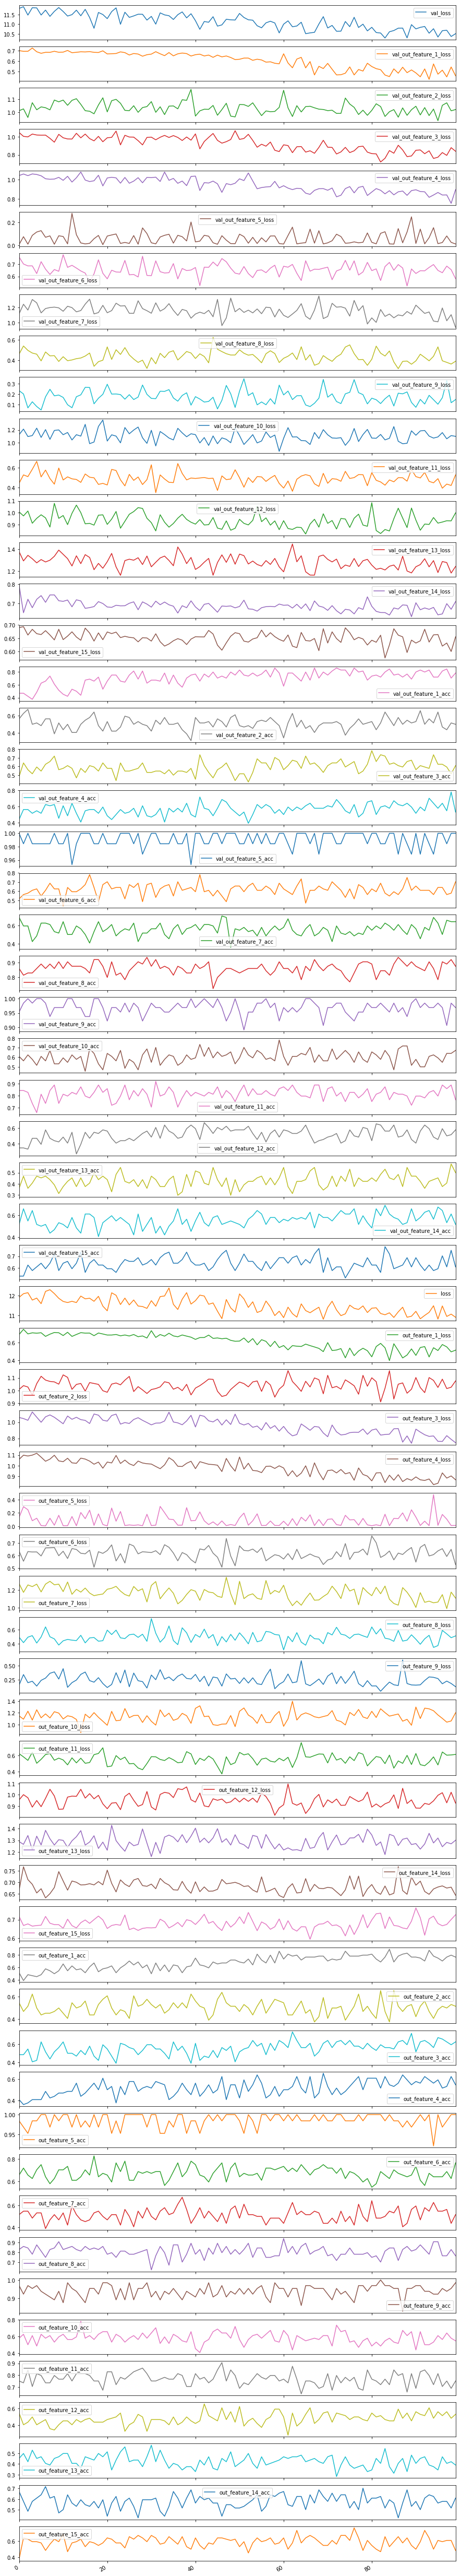

In [256]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<10.65]
df_hist.to_csv("human_features_weights_seen.csv")

In [415]:
df_hist.columns[32:47]


Index(['out_feature_1_loss', 'out_feature_2_loss', 'out_feature_3_loss',
       'out_feature_4_loss', 'out_feature_5_loss', 'out_feature_6_loss',
       'out_feature_7_loss', 'out_feature_8_loss', 'out_feature_9_loss',
       'out_feature_10_loss', 'out_feature_11_loss', 'out_feature_12_loss',
       'out_feature_13_loss', 'out_feature_14_loss', 'out_feature_15_loss'],
      dtype='object')

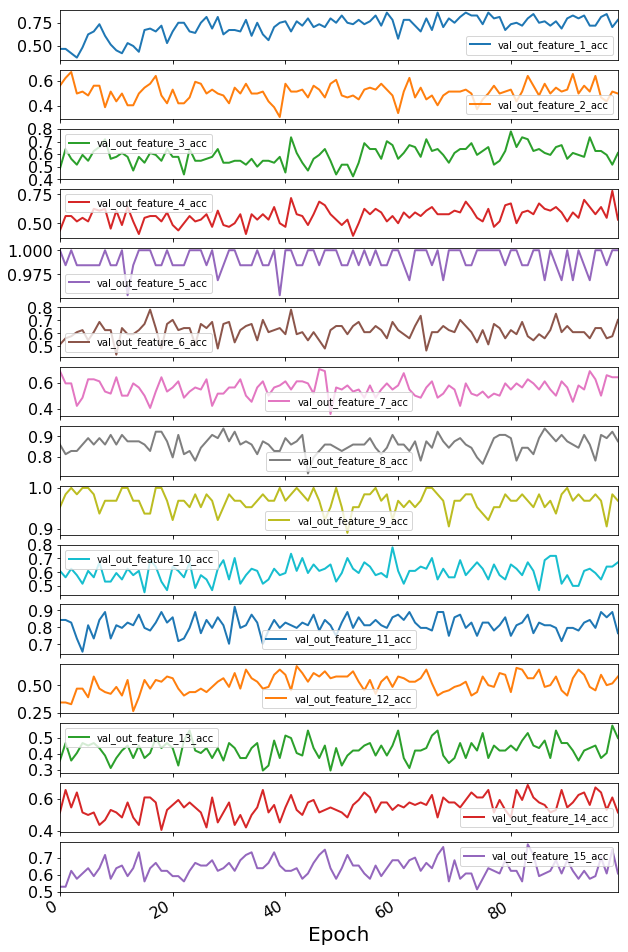

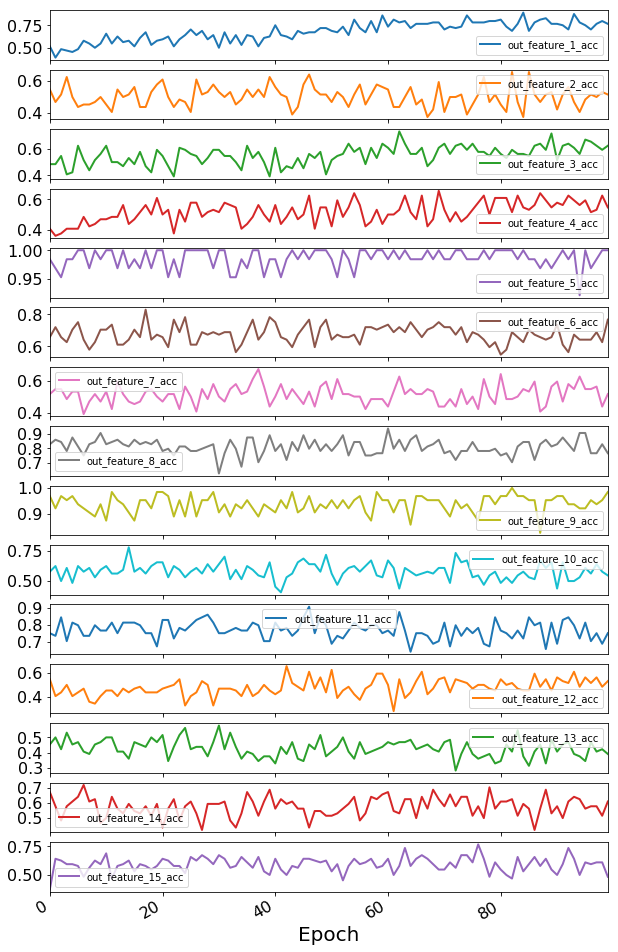

In [412]:
val_out_feature_acc=df_hist.columns[16:31]
fig_out=df_hist[val_out_feature_acc].plot(subplots=True,lw=2,figsize=(10,18), fontsize=16)[14]
fig_out.set_xlabel("Epoch",fontsize=20)
fig_out.get_figure().savefig("Diagram/val_out_feature_acc.pdf",bbox_inches='tight')

tr_out_feature_acc=df_hist.columns[47:62]
fig_out=df_hist[tr_out_feature_acc].plot(subplots=True, lw=2, figsize=(10,18), fontsize=16)[14]
fig_out.set_xlabel("Epoch",fontsize=20)
fig_out.get_figure().savefig("Diagram/tr_out_feature_acc.pdf",bbox_inches='tight')

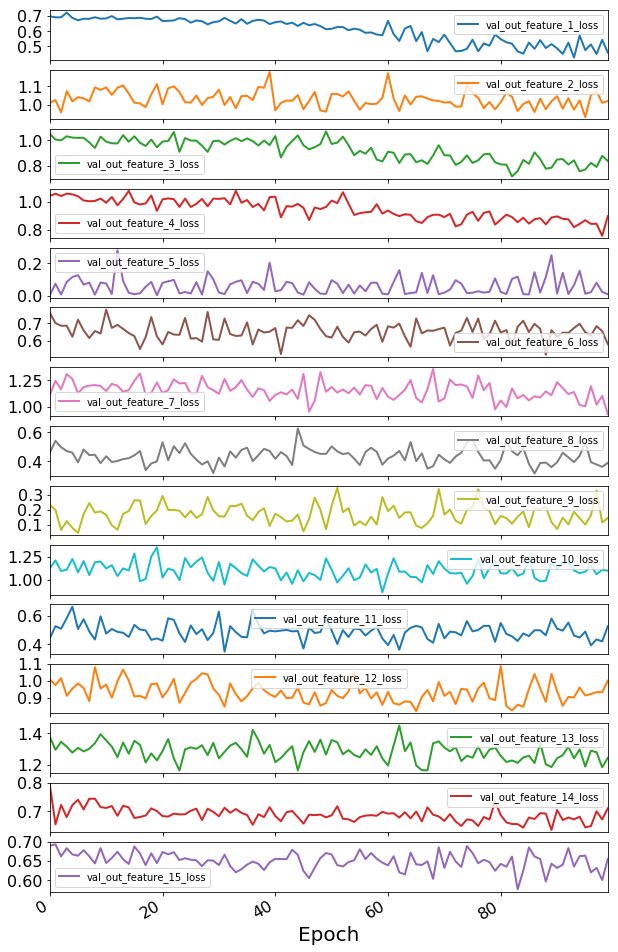

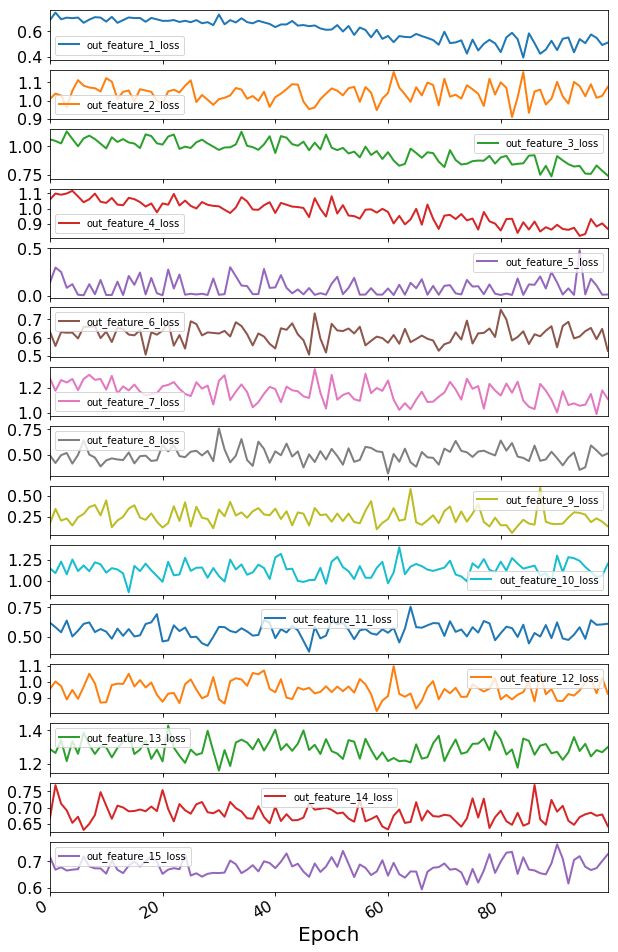

In [416]:
val_out_feature_loss=df_hist.columns[1:16]
fig_out=df_hist[val_out_feature_loss].plot(subplots=True,lw=2,figsize=(10,18), fontsize=16)[14]
fig_out.set_xlabel("Epoch",fontsize=20)
fig_out.get_figure().savefig("Diagram/val_out_feature_loss.pdf",bbox_inches='tight')

tr_out_feature_loss=df_hist.columns[32:47]
fig_out=df_hist[tr_out_feature_loss].plot(subplots=True, lw=2, figsize=(10,18), fontsize=16)[14]
fig_out.set_xlabel("Epoch",fontsize=20)
fig_out.get_figure().savefig("Diagram/tr_out_feature_loss.pdf",bbox_inches='tight')

# Evaluation

In [232]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

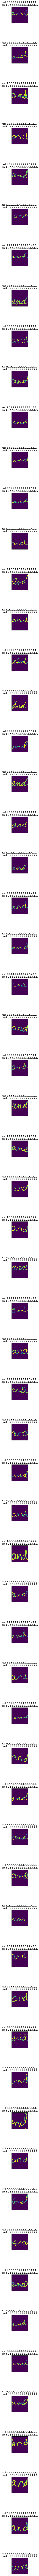

In [229]:
# human_features.load_weights('human_features_weights_v2.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):    
    real=''
    for f in range(15):
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
    pred=''
    for prob in f_probs:
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)

In [417]:
acc_list=[]
for i in range(1,16):
    acc=df_hist['val_out_feature_{0}_acc'.format(i)].max()
    los=df_hist['val_out_feature_{0}_loss'.format(i)].min()
    acc_list.append(acc)
    print('val_acc{}:'.format(i),acc, ', loss:', los)
print(np.mean(np.array(acc_list)))

val_acc1: 0.859375 , loss: 0.42666956782341003
val_acc2: 0.671875 , loss: 0.936616063117981
val_acc3: 0.78125 , loss: 0.7195565700531006
val_acc4: 0.78125 , loss: 0.7562835216522217
val_acc5: 1.0 , loss: 0.004840722307562828
val_acc6: 0.78125 , loss: 0.5217890739440918
val_acc7: 0.703125 , loss: 0.9342670440673828
val_acc8: 0.9375 , loss: 0.3151666820049286
val_acc9: 1.0 , loss: 0.04829131066799164
val_acc10: 0.78125 , loss: 0.8594774007797241
val_acc11: 0.921875 , loss: 0.34676671028137207
val_acc12: 0.671875 , loss: 0.8221315741539001
val_acc13: 0.578125 , loss: 1.1613539457321167
val_acc14: 0.6875 , loss: 0.6337602138519287
val_acc15: 0.78125 , loss: 0.576158881187439
0.7958333333333333


In [234]:
test_g = datagen(len(val_images)*5,val_path,val_images, csv_feature=csv_data_15feat,vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [465]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('all_feature').output)

In [259]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [261]:
feature_wise_pred_y=np.array(feature_wise_pred_y).reshape(15,4760,-1)
latent_pred_y=np.array(latent_pred_y).reshape(4760, -1)

In [297]:
latent_pred_y.shape,feature_wise_pred_y.shape

((4760, 8192), (15, 4760, 1024))

In [274]:
testy[0].shape,testy[1].shape

((4760,), (4760,))

In [307]:
num_sample=2000
index=np.arange(latent_pred_y.shape[0])
np.random.shuffle(index)
latent_pred_sample_y=latent_pred_y[index[0:num_sample],:]
feature_wise_pred_sample_y=feature_wise_pred_y[:,index[0:num_sample],:]
testy_sample=[testy[0][index[0:num_sample]],testy[1][index[0:num_sample]]]

In [309]:
latent_pred_sample_y.shape, feature_wise_pred_sample_y.shape, testy_sample[0].shape,testy_sample[1].shape

((2000, 8192), (15, 2000, 1024), (2000,), (2000,))

In [476]:
def get_latent_data(testy,latent_pred_y):
    ids = testy[0].reshape(-1,1)
    imagenames = testy[1].reshape(-1,1)
    data=[]
    for i in range(len(testy[0])):
        data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
    df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
    df_data=df_data.sort_values(by='identity').reset_index()
    display(df_data.head(10))
    return df_data
df_data=get_latent_data(testy_sample,latent_pred_sample_y) # image and latent varialbes
df_data.shape

,index,identity,imagename,latent
0,1551,0001,0001a_num2.png,"[0.0, 0.5493679, 0.13398167, 0.0, 0.0, 0.19049..."
1,74,0001,0001a_num2.png,"[0.0, 0.5331683, 0.12903012, 0.0, 0.0, 0.20692..."
2,800,0001,0001a_num1.png,"[0.066458195, 0.64949906, 0.1536968, 0.0, 0.0,..."
3,1291,0001,0001a_num1.png,"[0.0, 0.6176722, 0.14283143, 0.0, 0.0, 0.10090..."
4,1577,0001,0001a_num2.png,"[0.0, 0.32579106, 0.11154684, 0.13220993, 0.0,..."
5,910,0001,0001a_num2.png,"[0.0, 0.59421843, 0.13825525, 0.0, 0.0, 0.1467..."
6,246,0002,0002a_num2.png,"[0.07882251, 0.6178306, 0.14803812, 0.0, 0.0, ..."
7,1614,0002,0002a_num1.png,"[0.10220729, 0.6086359, 0.14108285, 0.0, 0.0, ..."
8,285,0002,0002a_num2.png,"[0.0, 0.4962516, 0.11958492, 0.0, 0.0, 0.16445..."
9,1237,0002,0002a_num2.png,"[0.0, 0.52028126, 0.10855541, 0.0, 0.0, 0.0941..."


(2000, 4)

In [316]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [317]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 20
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [418]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
display(df_cos_dist_out.head())
df_cos_dist_out.to_csv("similarity_out_overall.csv")


,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0001,0001a_num2.png,6,6,1110,884,0,0.006742,1.000000,0.013393,0.5580,2000,"[0002/0002a_num2.png, 0002/0002a_num1.png, 000...",[]
1,0001,0001a_num2.png,6,6,1127,867,0,0.006873,1.000000,0.013652,0.5665,2000,"[0002/0002a_num2.png, 0002/0002a_num1.png, 000...",[]
2,0001,0001a_num1.png,6,5,1114,880,1,0.005650,0.833333,0.011223,0.5595,2000,"[0002/0002a_num2.png, 0002/0002a_num1.png, 000...",[0001/0001a_num2.png]
3,0001,0001a_num1.png,6,6,1032,962,0,0.006198,1.000000,0.012320,0.5190,2000,"[0002/0002a_num2.png, 0002/0002a_num1.png, 000...",[]
4,0001,0001a_num2.png,6,5,1238,756,1,0.006570,0.833333,0.013038,0.6215,2000,"[0002/0002a_num2.png, 0002/0002a_num2.png, 000...",[0001/0001a_num1.png]


In [474]:
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)
print("Total num of TPs, TNs, FPs,FNs: ",tps, tns, fps, fns)
print("Total num of given images: ", total)

precision: 0.004616017074212828 
recall: 0.9063863546211821 
f1: 0.009185255755105405
Intra Writer Accuracy (Type 1): 0.9126667388167388
Inter Writer Accuracy (Type 2):: 0.5047484999999999
acc: 0.5070335
Total num of TPs, TNs, FPs,FNs:  9140 2018994 1970922 944
Total num of given images:  2000


In [482]:
df_data.head(10)

,index,identity,imagename,latent
0,1551,0001,0001a_num2.png,"[0.0, 0.5493679, 0.13398167, 0.0, 0.0, 0.19049..."
1,74,0001,0001a_num2.png,"[0.0, 0.5331683, 0.12903012, 0.0, 0.0, 0.20692..."
2,800,0001,0001a_num1.png,"[0.066458195, 0.64949906, 0.1536968, 0.0, 0.0,..."
3,1291,0001,0001a_num1.png,"[0.0, 0.6176722, 0.14283143, 0.0, 0.0, 0.10090..."
4,1577,0001,0001a_num2.png,"[0.0, 0.32579106, 0.11154684, 0.13220993, 0.0,..."
5,910,0001,0001a_num2.png,"[0.0, 0.59421843, 0.13825525, 0.0, 0.0, 0.1467..."
6,246,0002,0002a_num2.png,"[0.07882251, 0.6178306, 0.14803812, 0.0, 0.0, ..."
7,1614,0002,0002a_num1.png,"[0.10220729, 0.6086359, 0.14108285, 0.0, 0.0, ..."
8,285,0002,0002a_num2.png,"[0.0, 0.4962516, 0.11958492, 0.0, 0.0, 0.16445..."
9,1237,0002,0002a_num2.png,"[0.0, 0.52028126, 0.10855541, 0.0, 0.0, 0.0941..."


In [485]:
feature_wise_pred_sample_y.shape,df_data.shape

((15, 2000, 1024), (2000, 4))

7 6


,features,feature_similarity_score
0,pen_pressure,0.834736
1,letter_spacing,0.902451
2,size,0.887959
3,dimension,0.905624
4,is_lowercase,0.880200
5,is_continuous,0.833742
6,slantness,0.813491
7,tilt,0.829233
8,entry_stroke_a,0.884079
9,staff_of_a,0.888185


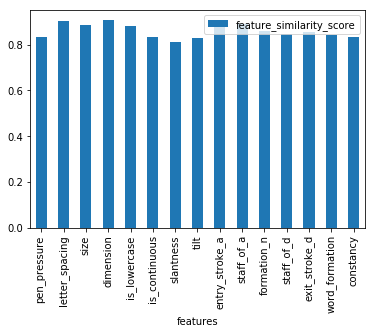

In [517]:
def get_latent_15feature(csv_data_15,pred_y, df_ori ,draw=False):
    index_l=df_ori[df_ori["imagename"]=="0002a_num1.png"].iloc[0:1].index.values[0] # first satisfied index
    index_r=df_ori[df_ori["imagename"]=="0002a_num2.png"].iloc[0:1].index.values[0]
    print(index_l, index_r)
    l = pred_y[:,index_l,:]
    r = pred_y[:,index_r,:]
    features = csv_data.keys()[1:]
    feature_similarity_score=cosine_similarity(l,r).diagonal()
    df_feat_sim_score = pd.DataFrame(columns=['features','feature_similarity_score'])
    df_feat_sim_score['features']=features
    df_feat_sim_score['feature_similarity_score']=feature_similarity_score
    display(df_feat_sim_score.head(10))
    df_feat_sim_score.plot.bar(x='features')
    df_feat_sim_score['feature_similarity_score'].mean()
    
get_latent_15feature(csv_data_15feat, feature_wise_pred_sample_y, df_data )

In [443]:
def get_latent_15feature_allpair(csv_data_15,pred_y):
    count=0
    dim=pred_y.shape[1]
    arr=np.zeros((int(dim*(dim-1)/2),15))
    df_feat_sim_score=pd.DataFrame(arr)
    df_data_15feat.columns=csv_data_15feat.columns[1:]
    for i in tqdm_notebook(range(pred_y.shape[1]-1)):
        l = pred_y[:,i,:]
        for j in range(i+1, pred_y.shape[1]):
            r = pred_y[:,j,:]
            features = csv_data.keys()[1:]
            feature_similarity_score=cosine_similarity(l,r).diagonal()
            df_feat_sim_score.iloc[count]=feature_similarity_score
            count+=1
    return df_feat_sim_score
#             display(df_feat_sim_score.head(10))
#             df_feat_sim_score['features']=features
#             df_feat_sim_score['feature_similarity_score']=feature_similarity_score
#             df_feat_sim_score.plot.bar(x='features')
#             df_feat_sim_score['feature_similarity_score'].mean()
df_data_15feat=get_latent_15feature_allpair(csv_data_15feat, feature_wise_pred_sample_y)
df_data_15feat.to_csv("similarity_out_15feat.csv")

In [450]:
display(df_data_15feat.head(10))

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0.750889,0.860234,0.860486,0.870462,0.831436,0.801492,0.788003,0.798789,0.819594,0.848198,0.801079,0.818300,0.810954,0.804741,0.799376
1,0.472863,0.727808,0.708034,0.756954,0.590659,0.609762,0.623657,0.583459,0.609743,0.724144,0.624692,0.670700,0.594024,0.534829,0.565534
2,0.928934,0.956388,0.962488,0.958561,0.948969,0.939447,0.931443,0.932094,0.944071,0.961504,0.936701,0.942353,0.937599,0.950317,0.933426
3,0.971595,0.986690,0.987640,0.988545,0.984459,0.974896,0.977826,0.979060,0.980390,0.985409,0.981580,0.983738,0.979195,0.982686,0.971078
4,0.401162,0.346051,0.304349,0.405155,0.437834,0.385842,0.317180,0.305621,0.403435,0.347394,0.304188,0.300836,0.389766,0.246379,0.262229
5,0.688295,0.888365,0.879473,0.907209,0.767467,0.840263,0.864741,0.828700,0.785716,0.904342,0.843589,0.896189,0.771662,0.761671,0.803237
6,0.508738,0.748303,0.733026,0.774804,0.628093,0.625770,0.645460,0.596236,0.650215,0.745489,0.660441,0.693516,0.611858,0.578297,0.599705
7,0.888978,0.957258,0.949562,0.957209,0.928182,0.932417,0.932494,0.925189,0.924315,0.954675,0.937522,0.952614,0.914296,0.930081,0.916989
8,0.468185,0.752102,0.743402,0.773934,0.612063,0.693352,0.698985,0.664757,0.608740,0.745603,0.666886,0.723333,0.622331,0.587186,0.619993
9,0.371284,0.574184,0.521560,0.614462,0.493421,0.492563,0.536939,0.410715,0.495312,0.566811,0.482684,0.511426,0.492423,0.393007,0.376284


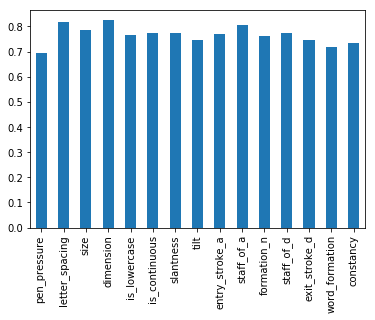

In [459]:
a=df_data_15feat[df_data_15feat.columns].mean()
a.plot.bar()